In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../../Code/')
sys.path.append('../')
from testWN import testWN as twm

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from RNN_tools import get_model, keras2casadi
from surrogate_model_training_data import get_data

# Data Pre-Processing

Get clusters:

In [5]:
cluster_labels = pd.read_json('150sim_cluster_labels.json')
pressure_factor = pd.read_json('150sim_pressure_factor.json')
n_clusters = 30

Get results:

In [101]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/'
file_list = os.listdir(data_path)[:5]
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
nn_input_list, nn_output_list = get_data(file_list, 0, cluster_labels, pressure_factor,
                                         narx_input=False, narx_output=False, return_lists=True)

## Normalize Data:

Scaling factors:

In [102]:
input_scaling = pd.concat(nn_input_list).abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5

output_scaling = pd.concat(nn_output_list).abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5

In [103]:
nn_input_list = [nn_in_i/input_scaling for nn_in_i in nn_input_list]
nn_output_list = [nn_out_i/output_scaling for nn_out_i in nn_output_list]

In [118]:
input_scaling = input_scaling.to_numpy().reshape(1,-1)
output_scaling = output_scaling.to_numpy().reshape(1,-1)

## RNN I/O structure

In [130]:
n_datasets = 5
seq_length = 20  # length of sequence for ANN training

n_data = nn_input_list[0].shape[0]
n_seq = n_data // seq_length - 1

# create sequences from the data:
X = []
Y = []
for data_i in range(n_datasets):
    X_train = nn_input_list[data_i].to_numpy()
    Y_train = nn_output_list[data_i].to_numpy()
    for offset in range(n_seq):
        for data_sample in range(n_seq):
            start_ind = data_sample*seq_length+offset
            X.append(X_train[start_ind:start_ind + seq_length, :])
            Y.append(Y_train[start_ind:start_ind + seq_length, :])

X = np.stack(X, axis=0)  # [m, seq_length, nx]
Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

batch_size = n_seq*n_datasets
nx = X.shape[2]
ny = Y.shape[2]

In [38]:
# seq_length = 20  # length of sequence for ANN training
# X_train = nn_input_list[0].to_numpy()
# Y_train = nn_output_list[0].to_numpy()

# # create sequences from the data:
# X = []
# Y = []

# n_data = X_train.shape[0]
# n_seq = n_data // seq_length - 1


# for offset in range(n_seq):
#     for data_sample in range(n_seq):
#         start_ind = data_sample*seq_length+offset
#         X.append(X_train[start_ind:start_ind + seq_length, :])
#         Y.append(Y_train[start_ind:start_ind + seq_length, :])

# X = np.stack(X, axis=0)  # [m, seq_length, nx]
# Y = np.stack(Y, axis=0)  # [m, seq_length, ny]

# batch_size = n_seq
# nx = X.shape[2]
# ny = Y.shape[2]

In [34]:
# If batch_size > 1 and stateful mode active, the order of the elements has to be adapted.
# batch_size = 5
# n_batches = X.shape[0]//batch_size
# n_data_red = batch_size*n_batches
# batch_ind = np.arange(n_data_red).reshape(-1, n_batches).T.ravel()

# X = X[batch_ind, :, :]
# Y = Y[batch_ind, :, :]

# nx = X.shape[2]
# ny = Y.shape[2]

# Create RNN

In [132]:
stateful = True
n_layer = 2  # hidden layer - output layer (linear) is automatically added
model_param = {}
model_param['RNN_param'] = {}
model_param['n_units'] = (n_layer) * [40]
model_param['p_dropout'] = None  # Placeholder. Not yet used.
model_param['activation'] = (n_layer) * ['tanh']

model_param['RNN_param']['RNN_type'] = 'LSTM'
model_param['RNN_param']['n_activation'] = 40
model_param['RNN_param']['recurrent_dropout'] = 0
model_param['RNN_param']['dropout'] = 0.
model_param['RNN_param']['implementation'] = 2

model = get_model(model_param, nx, ny, batch_size=batch_size,
                  seq_length=seq_length, stateful=stateful)

model.summary()

No value selected for dropout, choosing do=0.
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (35, 20, 40)              18720     
_________________________________________________________________
time_distributed_15 (TimeDis (35, 20, 40)              1640      
_________________________________________________________________
dropout_10 (Dropout)         (35, 20, 40)              0         
_________________________________________________________________
time_distributed_16 (TimeDis (35, 20, 40)              1640      
_________________________________________________________________
dropout_11 (Dropout)         (35, 20, 40)              0         
_________________________________________________________________
time_distributed_17 (TimeDis (35, 20, 42)              1722      
Total params: 23,722
Trainable params: 23,722
Non-trainable params: 0
____

In [ ]:
model.compile(loss='mse', optimizer='Adam')
if stateful:
    cb_reset = keras.callbacks.LambdaCallback(on_epoch_end=model.reset_states())
else:
    cb_reset = keras.callbacks.LambdaCallback()

cb_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-7, patience=10, mode='min')
model.fit(X, Y, callbacks=[cb_reset], batch_size=batch_size,
          epochs=1000, verbose=1, shuffle=not(stateful))

Train on 245 samples
Epoch 1/1000
245/245 [==============================] - 3s 12ms/sample - loss: 0.1332
Epoch 2/1000
245/245 [==============================] - 0s 808us/sample - loss: 0.0795
Epoch 3/1000
245/245 [==============================] - 0s 969us/sample - loss: 0.0576
Epoch 4/1000
245/245 [==============================] - 0s 914us/sample - loss: 0.0479
Epoch 5/1000
245/245 [==============================] - 0s 999us/sample - loss: 0.0439
Epoch 6/1000
245/245 [==============================] - 0s 848us/sample - loss: 0.0420
Epoch 7/1000
245/245 [==============================] - 0s 841us/sample - loss: 0.0401
Epoch 8/1000
245/245 [==============================] - 0s 816us/sample - loss: 0.0382
Epoch 9/1000
245/245 [==============================] - 0s 956us/sample - loss: 0.0364
Epoch 10/1000
245/245 [==============================] - 0s 1ms/sample - loss: 0.0347
Epoch 11/1000
245/245 [==============================] - 0s 857us/sample - loss: 0.0331
Epoch 12/1000
245/245 [

245/245 [==============================] - 0s 809us/sample - loss: 0.0090
Epoch 95/1000
245/245 [==============================] - 0s 787us/sample - loss: 0.0090
Epoch 96/1000
245/245 [==============================] - 0s 816us/sample - loss: 0.0090
Epoch 97/1000
245/245 [==============================] - 0s 822us/sample - loss: 0.0090
Epoch 98/1000
245/245 [==============================] - 0s 762us/sample - loss: 0.0089
Epoch 99/1000
245/245 [==============================] - 0s 768us/sample - loss: 0.0089
Epoch 100/1000
245/245 [==============================] - 0s 795us/sample - loss: 0.0089
Epoch 101/1000
245/245 [==============================] - 0s 793us/sample - loss: 0.0088
Epoch 102/1000
245/245 [==============================] - 0s 854us/sample - loss: 0.0088
Epoch 103/1000
245/245 [==============================] - 0s 776us/sample - loss: 0.0088
Epoch 104/1000
245/245 [==============================] - 0s 925us/sample - loss: 0.0088
Epoch 105/1000
245/245 [=================

245/245 [==============================] - 0s 840us/sample - loss: 0.0068
Epoch 279/1000
245/245 [==============================] - 0s 577us/sample - loss: 0.0069
Epoch 280/1000
245/245 [==============================] - 0s 575us/sample - loss: 0.0069
Epoch 281/1000
245/245 [==============================] - 0s 652us/sample - loss: 0.0070
Epoch 282/1000
245/245 [==============================] - 0s 630us/sample - loss: 0.0069
Epoch 283/1000
245/245 [==============================] - 0s 718us/sample - loss: 0.0068
Epoch 284/1000
245/245 [==============================] - 0s 610us/sample - loss: 0.0066
Epoch 285/1000
245/245 [==============================] - 0s 567us/sample - loss: 0.0067
Epoch 286/1000
245/245 [==============================] - 0s 589us/sample - loss: 0.0066
Epoch 287/1000
245/245 [==============================] - 0s 567us/sample - loss: 0.0065
Epoch 288/1000
245/245 [==============================] - 0s 666us/sample - loss: 0.0065
Epoch 289/1000
245/245 [============

Epoch 371/1000
245/245 [==============================] - 0s 2ms/sample - loss: 0.0055
Epoch 372/1000
245/245 [==============================] - 0s 2ms/sample - loss: 0.0055
Epoch 373/1000
245/245 [==============================] - 1s 2ms/sample - loss: 0.0055
Epoch 374/1000
245/245 [==============================] - 0s 2ms/sample - loss: 0.0055
Epoch 375/1000
245/245 [==============================] - 0s 2ms/sample - loss: 0.0055
Epoch 376/1000
245/245 [==============================] - 1s 2ms/sample - loss: 0.0055
Epoch 377/1000
245/245 [==============================] - 0s 2ms/sample - loss: 0.0056
Epoch 378/1000
245/245 [==============================] - 1s 2ms/sample - loss: 0.0055
Epoch 379/1000
245/245 [==============================] - 0s 2ms/sample - loss: 0.0056
Epoch 380/1000
245/245 [==============================] - 1s 2ms/sample - loss: 0.0056
Epoch 381/1000
245/245 [==============================] - 1s 3ms/sample - loss: 0.0056
Epoch 382/1000
245/245 [===================

245/245 [==============================] - 0s 618us/sample - loss: 0.0045
Epoch 556/1000
245/245 [==============================] - 0s 575us/sample - loss: 0.0045
Epoch 557/1000
245/245 [==============================] - 0s 845us/sample - loss: 0.0045
Epoch 558/1000
245/245 [==============================] - 0s 727us/sample - loss: 0.0044
Epoch 559/1000
245/245 [==============================] - 0s 587us/sample - loss: 0.0044
Epoch 560/1000
245/245 [==============================] - 0s 645us/sample - loss: 0.0044
Epoch 561/1000
245/245 [==============================] - 0s 587us/sample - loss: 0.0043
Epoch 562/1000
245/245 [==============================] - 0s 581us/sample - loss: 0.0044
Epoch 563/1000
245/245 [==============================] - 0s 920us/sample - loss: 0.0043
Epoch 564/1000
245/245 [==============================] - 0s 1ms/sample - loss: 0.0043
Epoch 565/1000
245/245 [==============================] - 0s 1ms/sample - loss: 0.0044
Epoch 566/1000
245/245 [================

# Evaluate Model

In [107]:
model_simple = get_model(model_param, nx, ny, batch_size=1,
                         seq_length=1, stateful=stateful)

model_simple.set_weights(model.get_weights())

model_simple.summary()
model_simple.reset_states()

No value selected for dropout, choosing do=0.
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (1, 1, 40)                18720     
_________________________________________________________________
time_distributed_12 (TimeDis (1, 1, 40)                1640      
_________________________________________________________________
dropout_8 (Dropout)          (1, 1, 40)                0         
_________________________________________________________________
time_distributed_13 (TimeDis (1, 1, 40)                1640      
_________________________________________________________________
dropout_9 (Dropout)          (1, 1, 40)                0         
_________________________________________________________________
time_distributed_14 (TimeDis (1, 1, 76)                3116      
Total params: 25,116
Trainable params: 25,116
Non-trainable params: 0
____

Initialize hidden state:

In [119]:
model_simple.reset_states()
sys_states = nn_input_list[0]['sys_states']
sys_inputs = nn_input_list[0]['sys_inputs']
# Initialize hidden state:
t = 0
dt = 3600
for i,in_i in nn_input.iloc[:seq_length].iterrows():
    rnn_in_i = in_i.to_numpy().reshape(1,-1)
    rnn_in_scaled = (rnn_in_i - input_offset)/input_scaling
    model_simple.predict(rnn_in_scaled.reshape(1,1,-1))
    t += dt

In [120]:
x_arr = [sys_states.iloc[seq_length].to_numpy().reshape(1,-1)]
t_arr = [t]
for i,u_i in sys_inputs.iloc[seq_length:].iterrows():
    rnn_in_i = np.concatenate((x_arr[-1],u_i.to_numpy().reshape(1,-1)),axis=1)
    rnn_in_scaled = (rnn_in_i - input_offset)/input_scaling
    rnn_out_scaled = model_simple.predict(rnn_in_scaled.reshape(1,1,-1))
    rnn_out = rnn_out_scaled.squeeze()*output_scaling+output_offset
    t_arr.append(t_arr[-1]+dt)
    x_arr.append(rnn_out[[0],:37])
    
res = np.concatenate(x_arr)

ValueError: operands could not be broadcast together with shapes (76,) (1,42) 

In [75]:
res = pd.DataFrame(res, columns=sys_states.columns, index=t_arr)

<IPython.core.display.Javascript object>


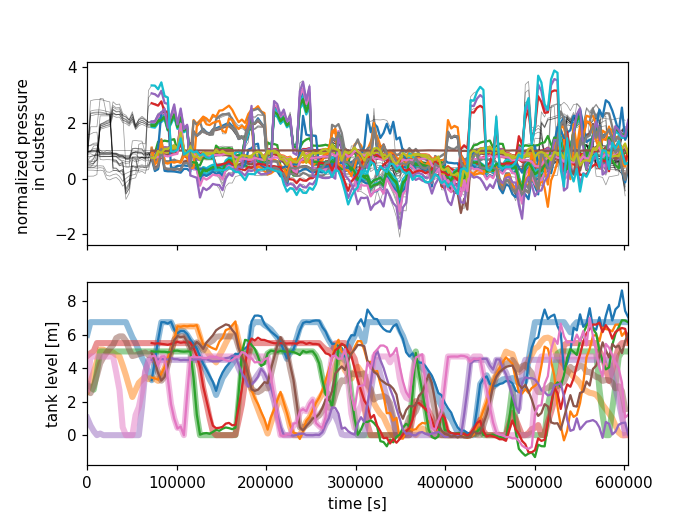

Text(0.5, 0, 'time [s]')

In [76]:
fig, ax = plt.subplots(2,1, sharex=True)

sys_states['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
res['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
res['tank_press'].plot(ax=ax[1], legend=False)

ax[0].set_xlim(0, res.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Keras 2 Casadi

In [39]:
from casadi import *

In [58]:
config = model_simple.get_config()
weights = model_simple.get_weights()

In [61]:
x_cas_in = MX.sym('x', 1, 76)
h_cas_in = MX.sym('h', 1, 40)
c_cas_in = MX.sym('c', 1, 40)

[x_cas_out, h_cas_out, c_cas_out], _ = keras2casadi(
    weights, config['layers'], [x_cas_in, h_cas_in, c_cas_in], backend_name='casadi')
fun = Function('fun', [x_cas_in, h_cas_in, c_cas_in], [x_cas_out, h_cas_out, c_cas_out])

In [84]:
x = np.ones((1, 76))
h = np.zeros((1, 40))
c = np.zeros((1, 40))

In [80]:
x = np.ones((1, 76))
x,h,c = fun(x,h,c)

In [81]:
x.full()

array([[ 0.373,  0.226,  0.37 ,  0.241,  0.196,  0.287,  0.187,  0.409,  0.645,  0.175,  0.205,  0.233,  0.417,  0.383,  0.798,  0.212,  0.273,  0.138,  0.154,  0.418,  0.298,  0.571,  0.215,  0.406,  0.177,  0.04 ,  0.184,  0.208,  0.207,  0.199, -0.18 ,  0.285, -0.061,  0.45 ,  0.316,  0.426,
         0.59 ,  0.218,  0.481,  0.312, -0.3  ,  0.324]])

In [77]:
model_simple.reset_states()

In [82]:
x = np.ones((1, 76))
model_simple.predict(x.reshape(1,1,-1))

array([[[ 0.373,  0.226,  0.37 ,  0.241,  0.196,  0.287,  0.187,  0.409,  0.645,  0.175,  0.205,  0.233,  0.417,  0.383,  0.798,  0.212,  0.273,  0.138,  0.154,  0.418,  0.298,  0.571,  0.215,  0.406,  0.177,  0.04 ,  0.184,  0.208,  0.207,  0.199, -0.18 ,  0.285, -0.061,  0.45 ,  0.316,  0.426,
          0.59 ,  0.218,  0.481,  0.312, -0.3  ,  0.324]]], dtype=float32)

# Create Full Training Dataset
Load data (lists of pandas objects)

In [38]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/'
file_list = os.listdir(data_path)[:40]
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
nn_input_list, nn_output_list = get_data(file_list, 0, cluster_labels, pressure_factor,
                                         narx_input=False, narx_output=False, return_lists=True)

Convert to list of numpy arrays:

In [39]:
nn_input_np_list = [i.to_numpy() for i in nn_input_list]
nn_output_np_list = [i.to_numpy() for i in nn_output_list]

Concatenate in time dimension:

In [40]:
nn_input_concat = np.concatenate(nn_input_np_list,axis =0)
nn_output_concat = np.concatenate(nn_output_np_list,axis =0)

Normalize data:

1.) Get factors:

In [41]:
input_offset = nn_input_concat.mean(axis=0, keepdims=True)
nn_input_offset = nn_input_concat - input_offset
input_scaling = np.max(np.abs(nn_input_offset),axis=0, keepdims=True)
input_scaling = np.maximum(input_scaling, 1e-5)

output_offset = nn_output_concat.mean(axis=0, keepdims=True)
nn_output_offset = nn_output_concat - output_offset
output_scaling = np.max(np.abs(nn_output_offset),axis=0, keepdims=True)
output_scaling =  np.maximum(output_scaling, 1e-5)

2.) Apply to list:

In [42]:
nn_input_np_list_norm = [(i-input_offset)/input_scaling for i in nn_input_np_list]
nn_output_np_list_norm = [(i-output_offset)/output_scaling for i in nn_output_np_list]

Stack lists:

In [43]:
nn_input_stacked = np.stack(nn_input_np_list_norm, axis=0)
nn_output_stacked = np.stack(nn_output_np_list_norm, axis=0)

In [48]:
seq_length = 20  # length of sequence for ANN training

# create sequences from the data:
X = []
Y = []

n_data = nn_input_stacked.shape[1]
n_seq = n_data // seq_length - 1



for data_sample in range(n_seq):
    start_ind = data_sample*seq_length
    X.append(nn_input_stacked[:,start_ind:start_ind + seq_length, :])
    Y.append(nn_output_stacked[:,start_ind:start_ind + seq_length, :])
    
X = np.concatenate(X, axis=0)  # [m, seq_length, nx]
Y = np.concatenate(Y, axis=0)  # [m, seq_length, ny]

In [49]:
batch_size=40
nx = X.shape[2]
ny = Y.shape[2]
X.shape

(1280, 20, 76)